# Brand Sentiment Analysis with NLP

## Overview
X-Sight is an analytical company which provides analytical solutions to the major companies regarding there products, market analysis, sales analysis. Pine-Apple has hired X-Sight to perform a large-scale market sentiment analysis on their products. In order to perform such analysis, X-Sight is relying on Machine Learning to predict public sentiment from text data. For this purpose, X-Sight is looking into twitter text data to predict if the given text has positive or negative sentiment towards a particular brand. 

### Problem Statement
Given the size and complexity of the tweet dataset, is it feasible to implement a Machine Learning model using Natural Language Processing to predict corrent sentiment of a given tweet.

### Busines Value
Sentiment analysis on a brand and its product will allow companies to adjust their marketing campaign to align with general public. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import os

In [2]:
import re
import nltk
import string
from nltk import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import spacy
# nlp = spacy.load("en_core_web_sm")

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm

In [ ]:
# Check GPU status
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smnge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\smnge\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\smnge\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
data = pd.read_csv("D:/FLATIRON/Projects/Sentiment_Analysis/judge-1377884607_tweet_product_company.csv", 
                       encoding='unicode_escape')
data.head()

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<AxesSubplot:xlabel='is_there_an_emotion_directed_at_a_brand_or_product', ylabel='count'>

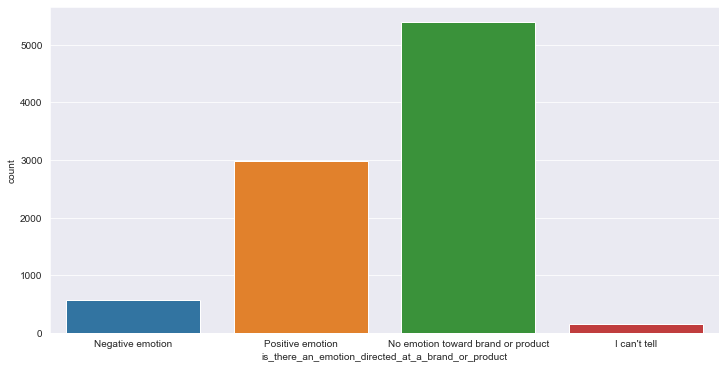

In [7]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=data)

There are altogether four sentiment classes in which neutral type of emotion ('No emotion...') is more prevalent. We can also see the sentiment 'I can't tell' constitutes only tiny portion of the data. Sentiment wise, this might be closer to the neutral type in which case we may  combine this to the neutral class. However, this class is already a majority class which is already causing huge imbalance in the dataset. So, we will drop the data with this class label.

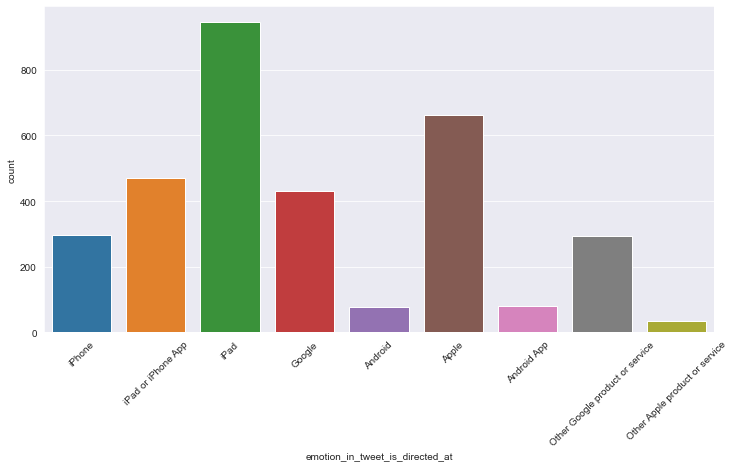

In [8]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='emotion_in_tweet_is_directed_at', data=data)
plt.xticks(rotation=45);

The tweet data are dispersed into several brands under Apple and Google. We will consolidate these information into these two major brands.

### Data Preparation

In [8]:
# Create a working dataframe with easier column name
df = data.copy(deep=True)
df.drop_duplicates(subset=['tweet_text'], inplace=True)
df.dropna(subset=['tweet_text'], inplace=True)
df.rename(columns = {'emotion_in_tweet_is_directed_at':'brand_item', 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace=True)

# Convert the data types to string
df['tweet_text'] = df['tweet_text'].astype(str)
df['brand_item'] = df['brand_item'].astype(str)

# Brand name mapping
brand = {'iPhone': 'apple',
         'iPad or iPhone App':'apple',
         'iPad': 'apple',
         'Google': 'google',
         'nan': 'UNK',
         'Android':'google',
         'Apple': 'apple',
         'Android App':'google',
         'Other Google product or service':'google',
         'Other Apple product or service':'apple'
        }

df['brand_name'] = df['brand_item'].map(brand)

# Encoding class label to brief
label_encoder = {'Negative emotion': 'negative',
                 'Positive emotion': 'positive',
                 'No emotion toward brand or product': 'neutral',
                 "I can't tell":'confused'}

df['emotion'] = df['emotion'].map(label_encoder)
df = df[df['emotion'] != 'confused']    # drop the rows containing 'confused' labels

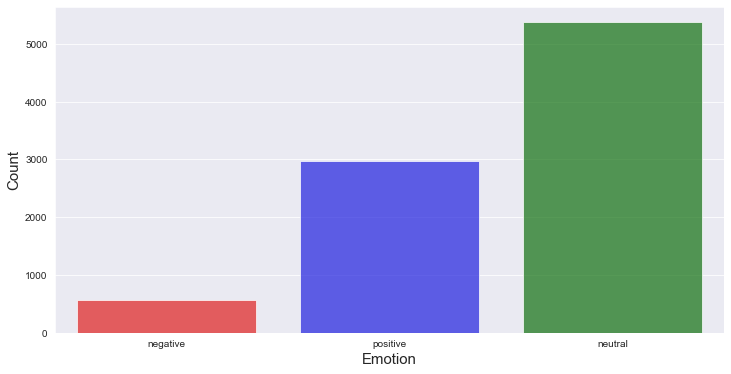

In [9]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='emotion', data=df,  
              palette={'positive':'b', 'negative':'r', 'neutral':'g'}, alpha=0.7)
plt.xlabel('Emotion', fontsize=15)
plt.ylabel('Count', fontsize=15);

In [10]:
df.emotion.value_counts(normalize=True)

neutral     0.602986
positive    0.333146
negative    0.063868
Name: emotion, dtype: float64

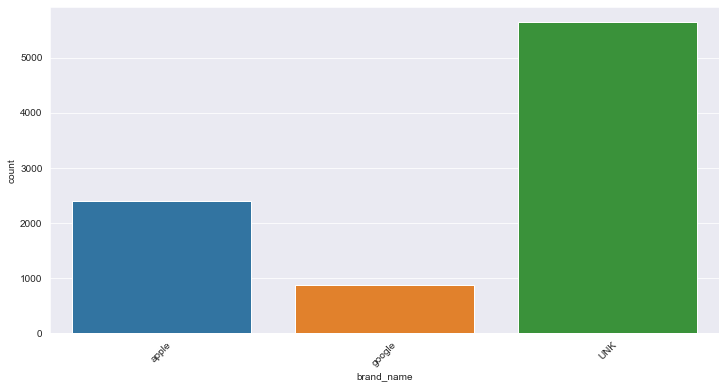

In [11]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='brand_name', data=df)
plt.xticks(rotation=45);

We can see, the number of tweets associated with the Apple is far greater than Google. So, we will need to use a % difference between these two brands when comparing against one another.

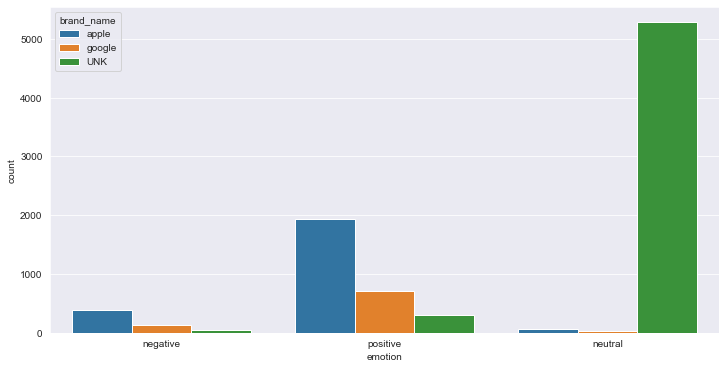

In [12]:
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df, x = 'emotion', hue='brand_name')

### Data Augmentation

We can see there is a huge imbalance in the class label, especially the proportion of negative emotion is significantly low. In the next data we will add few rows of data with negative class label from a different twitter dataset. The dataset is mainly about he Apple product.

In [13]:
df = df[['emotion', 'tweet_text']]
df.head()

emotion                                         tweet_text
0  negative  .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1  positive  @jessedee Know about @fludapp ? Awesome iPad/i...
2  positive  @swonderlin Can not wait for #iPad 2 also. The...
3  negative  @sxsw I hope this year's festival isn't as cra...
4  positive  @sxtxstate great stuff on Fri #SXSW: Marissa M...

In [14]:
data2 = pd.read_csv("D:/FLATIRON/Projects/Sentiment_Analysis/Apple-Twitter-Sentiment-DFE.csv", 
                   encoding='unicode_escape')

data2 = data2.loc[:, ('sentiment', 'text')].astype(str)
data2_neg = data2.loc[data2['sentiment']=='1']
data2_neg['sentiment'] = data2_neg.loc[:, ('sentiment')].apply(lambda x: 'negative')
data2_neg.rename(columns = {'sentiment':'emotion', 'text':'tweet_text'}, inplace=True)

<ipython-input-14-186d095e574c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2_neg['sentiment'] = data2_neg.loc[:, ('sentiment')].apply(lambda x: 'negative')
C:\Users\smnge\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [15]:
data2_neg

emotion                                         tweet_text
10    negative  WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
14    negative  @apple Contact sync between Yosemite and iOS8 ...
16    negative  WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM ...
23    negative  @Apple, For the love of GAWD, CENTER the '1'on...
24    negative  i get the storage almost full notification lit...
...        ...                                                ...
3855  negative  RT @Ecofantasy: Thinking of upgrading to #Yose...
3857  negative         why isnt group facetime a thing @apple wtf
3877  negative  Being held hostage at @apple - They are replac...
3880  negative  hey @apple is it normal for my laptop charger ...
3884  negative  My iPhone 5's photos are no longer downloading...

[1219 rows x 2 columns]

In [16]:
df = df.append(data2_neg)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10128 entries, 0 to 3884
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   emotion     10128 non-null  object
 1   tweet_text  10128 non-null  object
dtypes: object(2)
memory usage: 237.4+ KB


Text(0, 0.5, 'Count')

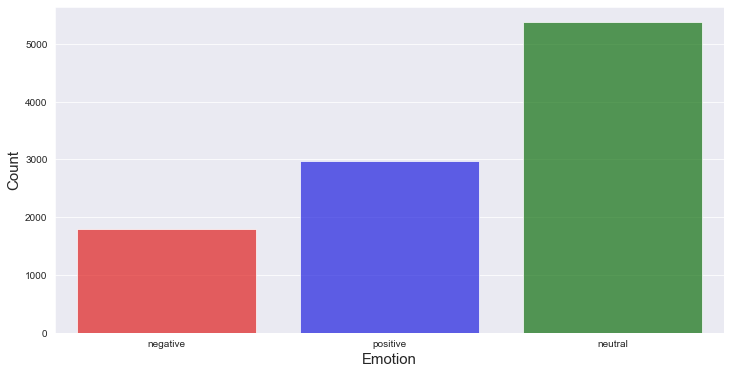

In [18]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='emotion', data=df,
             palette={'positive':'b', 'negative':'r', 'neutral':'g'}, alpha=0.7)
plt.xlabel('Emotion', fontsize=15)
plt.ylabel('Count', fontsize=15)

In [19]:
df.emotion.value_counts(normalize=True)

neutral     0.530411
positive    0.293049
negative    0.176540
Name: emotion, dtype: float64

### Text Preprocessing

Before we start modeling, it is important to clean up the text data which may contain too many unnecessary letters, symbols. Let's check few example of current text in the data.

In [20]:
df.tweet_text.head(10)

0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1     @jessedee Know about @fludapp ? Awesome iPad/i...
2     @swonderlin Can not wait for #iPad 2 also. The...
3     @sxsw I hope this year's festival isn't as cra...
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...
5     @teachntech00 New iPad Apps For #SpeechTherapy...
7     #SXSW is just starting, #CTIA is around the co...
8     Beautifully smart and simple idea RT @madebyma...
9     Counting down the days to #sxsw plus strong Ca...
10    Excited to meet the @samsungmobileus at #sxsw ...
Name: tweet_text, dtype: object

Punctuation is one of the major problem in text analysis, so it needs to be removed from the text. However, sometime it may affect the words such as: 'you're, I've,...' because it will basically try to remove the letter around apostrophe, and thus altering the context. Below, we will implement a detail contraction mapping such that contracted words are expanded to theirs full form.

In [21]:
contraction_map = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" } 

In [22]:
def contraction_mapping(text):
    '''
    Function to map contraction to the text.
    '''   

    apostrophe_handled = re.sub("’", "'", text)
    expanded = ' '.join([contraction_map[t] if t in contraction_map else t for t in apostrophe_handled.split(" ")])
    

    return expanded

In [23]:
# Test the function
row = 11
print('Before contraction:', '\n',  df['tweet_text'][row])
print('\nAfter contraction:', '\n', contraction_mapping(df['tweet_text'][row]))

Before contraction: 
 Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I can't wait til the Android app comes out.

After contraction: 
 Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I cannot wait til the Android app comes out.


In [24]:
# Apply contraction mapping
df['expanded_tweets'] = df['tweet_text'].apply(contraction_mapping)

In [25]:
def tweet_cleaner(tweet):
    '''
    Function to remove punctuations, special characters, html links, twitter handels etc...
    '''
    
    stopwords = ['rt','rts', 'retweet', 'quot', 'sxsw']
    
    punctuation = set(string.punctuation) # punctuation of English language
    punctuation.remove('#') # remove # so hashtags remain in x
    
    x = tweet
    x = re.sub(r'https?:\/\/\S+', '', x) # remove URL references
    x = re.sub(r'{link}', '', x)  # remove placeholders
    x = re.sub(r'@[\w]*', '', x) # remove @mention users
    x = re.sub('[^A-Za-z0-9]+', ' ', x) # remove @mention users
    x = re.sub(r'\b[0-9]+\b', '', x) # remove stand-alone numbers  
    x = re.sub(r'&[a-z]+;', '', x) # remove HTML reference characters
    x = ''.join(ch for ch in x if ch not in punctuation) # remove punctuation
    x = x.replace("[^a-zA-z#]", " ")  #remove special characters

    x = [word.lower() for word in x.split() if word.lower() not in stopwords]
    x = [w for w in x if len(w)>2]

    return ' '.join(x)

In [26]:
# Test the function
row = 11
print('Before cleanup:', '\n',  df['expanded_tweets'][row])
print('\nAfter cleanup:', '\n', tweet_cleaner(df['expanded_tweets'][row]))

Before cleanup: 
 Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I cannot wait til the Android app comes out.

After cleanup: 
 find amp start impromptu parties with cannot wait til the android app comes out


In [27]:
# Apply the tweet cleaner to whole dataframe  
df['clean_tweets1'] = df['expanded_tweets'].apply(tweet_cleaner)

# Word count of all the vocabulary
FreqDist(df['clean_tweets1'].unique().sum().split())

FreqDist({'the': 3574, 'for': 2021, 'ipad': 1674, 'apple': 1570, 'google': 1406, 'and': 1400, 'iphone': 1207, 'store': 1071, 'you': 867, 'not': 762, ...})

We can see the word 'the' is the most common word. While for architecture like LSTM, we might need to retain these kinds of stopwords, but the more simple models like Naive Bayes, we would like to get rid of these words. So, we will create another set of words particularly to train Naive Bayes like algorithms.

In [28]:
def remove_stopwords(tweet):      
    stopwords_removed = [word for word in tweet.split() if word not in stopwords.words('english')]
    return ' '.join(stopwords_removed)                         

In [29]:
# Apply the tweet cleaner to whole dataframe  
df['clean_tweets2'] = df['clean_tweets1'].apply(remove_stopwords)

# Word count of all the vocabulary
FreqDist(df['clean_tweets2'].unique().sum().split())

FreqDist({'ipad': 1588, 'apple': 1493, 'google': 1315, 'iphone': 1142, 'store': 1042, 'new': 693, 'amp': 622, 'austin': 601, 'app': 571, 'pop': 453, ...})

In [30]:
df

emotion                                         tweet_text  \
0     negative  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     positive  @jessedee Know about @fludapp ? Awesome iPad/i...   
2     positive  @swonderlin Can not wait for #iPad 2 also. The...   
3     negative  @sxsw I hope this year's festival isn't as cra...   
4     positive  @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...        ...                                                ...   
3855  negative  RT @Ecofantasy: Thinking of upgrading to #Yose...   
3857  negative         why isnt group facetime a thing @apple wtf   
3877  negative  Being held hostage at @apple - They are replac...   
3880  negative  hey @apple is it normal for my laptop charger ...   
3884  negative  My iPhone 5's photos are no longer downloading...   

                                        expanded_tweets  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival is not as cr...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
3855  RT @Ecofantasy: Thinking of upgrading to #Yose...   
3857         why isnt group facetime a thing @apple wtf   
3877  Being held hostage at @apple - They are replac...   
3880  hey @apple is it normal for my laptop charger ...   
3884  My iPhone 5's photos are no longer downloading...   

                                          clean_tweets1  \
0     have iphone after hrs tweeting rise austin was...   
1     know about awesome ipad iphone app that you wi...   
2     can not wait for ipad also they should sale th...   
3     hope this year festival not crashy this year i...   
4     great stuff fri marissa mayer google tim reill...   
...                                                 ...   
3855  thinking upgrading yosemite think twice not fo...   
3857                  why isnt group facetime thing wtf   
3877  being held hostage they are replacing the whol...   
3880  hey normal for laptop charger soldering itself...   
3884  iphone photos are longer downloading automatic...   

                                          clean_tweets2  
0     iphone hrs tweeting rise austin dead need upgr...  
1     know awesome ipad iphone app likely appreciate...  
2                                   wait ipad also sale  
3             hope year festival crashy year iphone app  
4     great stuff fri marissa mayer google tim reill...  
...                                                 ...  
3855  thinking upgrading yosemite think twice everyo...  
3857                      isnt group facetime thing wtf  
3877  held hostage replacing whole phone last backup...  
3880    hey normal laptop charger soldering skin thanks  
3884  iphone photos longer downloading automatically...  

[10128 rows x 5 columns]

In [31]:
def normalization(tweet):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet.split():
        normalized_text = lem.lemmatize(word, 'v')
        normalized_tweet.append(normalized_text)
    return ' '.join(normalized_tweet)

In [32]:
# Apply the tweet cleaner to whole dataframe  
df['clean_tweets3'] = df['clean_tweets2'].apply(normalization)

# Word count of all the vocabulary
FreqDist(df['clean_tweets3'].unique().sum().split())

FreqDist({'ipad': 1586, 'apple': 1492, 'google': 1314, 'iphone': 1141, 'store': 1077, 'new': 691, 'amp': 619, 'austin': 601, 'app': 570, 'get': 526, ...})

In [33]:
df

emotion                                         tweet_text  \
0     negative  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     positive  @jessedee Know about @fludapp ? Awesome iPad/i...   
2     positive  @swonderlin Can not wait for #iPad 2 also. The...   
3     negative  @sxsw I hope this year's festival isn't as cra...   
4     positive  @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...        ...                                                ...   
3855  negative  RT @Ecofantasy: Thinking of upgrading to #Yose...   
3857  negative         why isnt group facetime a thing @apple wtf   
3877  negative  Being held hostage at @apple - They are replac...   
3880  negative  hey @apple is it normal for my laptop charger ...   
3884  negative  My iPhone 5's photos are no longer downloading...   

                                        expanded_tweets  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival is not as cr...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
3855  RT @Ecofantasy: Thinking of upgrading to #Yose...   
3857         why isnt group facetime a thing @apple wtf   
3877  Being held hostage at @apple - They are replac...   
3880  hey @apple is it normal for my laptop charger ...   
3884  My iPhone 5's photos are no longer downloading...   

                                          clean_tweets1  \
0     have iphone after hrs tweeting rise austin was...   
1     know about awesome ipad iphone app that you wi...   
2     can not wait for ipad also they should sale th...   
3     hope this year festival not crashy this year i...   
4     great stuff fri marissa mayer google tim reill...   
...                                                 ...   
3855  thinking upgrading yosemite think twice not fo...   
3857                  why isnt group facetime thing wtf   
3877  being held hostage they are replacing the whol...   
3880  hey normal for laptop charger soldering itself...   
3884  iphone photos are longer downloading automatic...   

                                          clean_tweets2  \
0     iphone hrs tweeting rise austin dead need upgr...   
1     know awesome ipad iphone app likely appreciate...   
2                                   wait ipad also sale   
3             hope year festival crashy year iphone app   
4     great stuff fri marissa mayer google tim reill...   
...                                                 ...   
3855  thinking upgrading yosemite think twice everyo...   
3857                      isnt group facetime thing wtf   
3877  held hostage replacing whole phone last backup...   
3880    hey normal laptop charger soldering skin thanks   
3884  iphone photos longer downloading automatically...   

                                          clean_tweets3  
0     iphone hrs tweet rise austin dead need upgrade...  
1     know awesome ipad iphone app likely appreciate...  
2                                   wait ipad also sale  
3             hope year festival crashy year iphone app  
4     great stuff fri marissa mayer google tim reill...  
...                                                 ...  
3855  think upgrade yosemite think twice everyone asmsg  
3857                      isnt group facetime thing wtf  
3877  hold hostage replace whole phone last backup m...  
3880        hey normal laptop charger solder skin thank  
3884  iphone photos longer download automatically la...  

[10128 rows x 6 columns]

## Modeling
We will start with simple scikit learn modeling. We will test Naive Bayes on tweets with and without lemmatization

In [34]:
X = df[['clean_tweets2']] 
y = df['emotion']

#### We will take aside 10% of data for Test Set, and further split training data into validation set

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6815, 1), (1203, 1), (891, 1), (6815,), (1203,), (891,))

In [345]:
# Vectorizing
tfidf_vectorizer = TfidfVectorizer()

X_train_vec = tfidf_vectorizer.fit_transform(X_train['clean_tweets2']).toarray()
X_test_vec = tfidf_vectorizer.transform(X_test['clean_tweets2']).toarray()
X_val_vec = tfidf_vectorizer.transform(X_val['clean_tweets2']).toarray()

In [346]:
X_train_vec.shape, X_val_vec.shape

((7747, 8878), (1368, 8878))

In [347]:
X_train

clean_tweets2
1040  retiring wine library moving onto daily grape ...
7958  saw going download groundlink app amp ride lim...
5358        social apps make intimate sxswi apps iphone
5805           google announces check ins coupons deals
4977  digging john mcree talk designing boomers mayb...
...                                                 ...
6609  texas observer tomlinson says would double rev...
3563  think got bought something apple assumes apple...
4559                   iphone find one gadget going bag
7199  missed touchingstories catch web touching stor...
1956  calyp app today avail itunes app store amp and...

[7747 rows x 1 columns]

In [348]:
# Simple Naive Bayes classifer 
clf1_NB = MultinomialNB()
clf1_NB.fit(X_train_vec, y_train)

MultinomialNB()

In [23]:
def get_prediction(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print('Training Prediction')
    print('--------------------')
    print(classification_report(y_train, y_train_pred))
    print('Test Prediction')
    print('--------------------')
    print(classification_report(y_test, y_test_pred))
    
    return y_train_pred, y_test_pred

In [350]:
_, _ = get_prediction(clf1_NB, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.99      0.61      0.76      1368
     neutral       0.71      0.98      0.83      4109
    positive       0.90      0.48      0.63      2270

    accuracy                           0.77      7747
   macro avg       0.87      0.69      0.74      7747
weighted avg       0.82      0.77      0.76      7747

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.96      0.45      0.61       241
     neutral       0.62      0.94      0.74       726
    positive       0.66      0.24      0.36       401

    accuracy                           0.65      1368
   macro avg       0.75      0.54      0.57      1368
weighted avg       0.69      0.65      0.61      1368



In [352]:
# Instantiate a Random Forest Classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=6, class_weight='balanced')
clf_rf.fit(X_train_vec, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=6, random_state=0)

In [353]:
_, _ = get_prediction(clf_rf, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.97      1.00      0.98      1368
     neutral       0.98      0.95      0.96      4109
    positive       0.93      0.96      0.94      2270

    accuracy                           0.96      7747
   macro avg       0.96      0.97      0.96      7747
weighted avg       0.96      0.96      0.96      7747

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.82      0.68      0.74       241
     neutral       0.68      0.82      0.75       726
    positive       0.62      0.45      0.52       401

    accuracy                           0.69      1368
   macro avg       0.71      0.65      0.67      1368
weighted avg       0.69      0.69      0.68      1368



In [354]:
# Next we try to fit Naive Bayes on lemmatized data
X = df[['clean_tweets3']] 

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7747, 1), (1368, 1), (1013, 1), (7747,), (1368,), (1013,))

In [356]:
# Vectorizing
tfidf_vectorizer = TfidfVectorizer()

X_train_vec = tfidf_vectorizer.fit_transform(X_train['clean_tweets3']).toarray()
X_test_vec = tfidf_vectorizer.transform(X_test['clean_tweets3']).toarray()
X_val_vec = tfidf_vectorizer.transform(X_val['clean_tweets3']).toarray()

In [357]:
# Simple Naive Bayes classifer 
clf2_NB = MultinomialNB()
clf2_NB.fit(X_train_vec, y_train)

MultinomialNB()

In [358]:
_, _ = get_prediction(clf2_NB, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.99      0.60      0.75      1368
     neutral       0.70      0.98      0.82      4109
    positive       0.89      0.44      0.58      2270

    accuracy                           0.76      7747
   macro avg       0.86      0.67      0.72      7747
weighted avg       0.80      0.76      0.74      7747

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.96      0.46      0.62       241
     neutral       0.61      0.93      0.74       726
    positive       0.62      0.24      0.34       401

    accuracy                           0.64      1368
   macro avg       0.73      0.54      0.57      1368
weighted avg       0.68      0.64      0.60      1368



In [359]:
# Instantiate a Random Forest Classifier
clf_rf2 = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=6)
clf_rf2.fit(X_train_vec, y_train)

RandomForestClassifier(n_jobs=6, random_state=0)

In [360]:
_, _ = get_prediction(clf_rf2, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.99      0.98      0.99      1368
     neutral       0.95      0.98      0.96      4109
    positive       0.96      0.92      0.94      2270

    accuracy                           0.96      7747
   macro avg       0.97      0.96      0.96      7747
weighted avg       0.96      0.96      0.96      7747

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.83      0.67      0.74       241
     neutral       0.67      0.86      0.76       726
    positive       0.66      0.40      0.50       401

    accuracy                           0.69      1368
   macro avg       0.72      0.65      0.67      1368
weighted avg       0.70      0.69      0.68      1368



We do not see any major improvement when using lemmatized data for both Naive Bayes and Random Forest. However, in general, an accuracy of 64% is a good baseline for any text classification. Next we will test Neural Network based classification using LSTM and GRU. 

## Neural Networks

In [35]:
import warnings
warnings.filterwarnings('ignore')

#### One-hot-encoding
One of the requirement for Tensorflow is that our output class label needs to be one-hot encoded.

In [36]:
X = df['clean_tweets1']
y_ohe = pd.get_dummies(df['emotion'])
print(X.iloc[:3], y_ohe.iloc[:3])

0    have iphone after hrs tweeting rise austin was...
1    know about awesome ipad iphone app that you wi...
2    can not wait for ipad also they should sale th...
Name: clean_tweets1, dtype: object    negative  neutral  positive
0         1        0         0
1         0        0         1
2         0        0         1


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.10, stratify=y_ohe,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((7747,), (1368,), (1013,), (7747, 3), (1368, 3), (1013, 3))

#### Tokenization

In [38]:
def create_tokens(X_train, X_val, X_test):
    '''
    A simple function to create word tokens with padded sequences
    '''
    tokenizer = Tokenizer(oov_token=True)
    tokenizer.fit_on_texts(X_train)
    
    X_train_token = tokenizer.texts_to_sequences(X_train)
    X_test_token = tokenizer.texts_to_sequences(X_test)
    X_val_token = tokenizer.texts_to_sequences(X_val)
    
    vocab_size = len(tokenizer.word_index) + 1
    
    maxlen = len(max(X_train_token, key=lambda x: len(x)))
    maxlen_orig= len(max(X_train, key=lambda x: len(x)))
    
    X_train_seq = pad_sequences(X_train_token, padding='post', maxlen=maxlen)
    X_test_seq = pad_sequences(X_test_token, padding='post', maxlen=maxlen)
    X_val_seq = pad_sequences(X_val_token, padding='post', maxlen=maxlen)
    
    print(f"Token count: {tokenizer.document_count}, Vocab size: {vocab_size}, Max lenth: {maxlen}, Original length: {maxlen_orig}")
    
    return X_train_seq, X_test_seq, X_val_seq, maxlen, vocab_size, tokenizer

In [39]:
X_train_seq, X_test_seq, X_val_seq, maxlen, vocab_size, tokenizer = create_tokens(X_train, X_val, X_test)

Token count: 7747, Vocab size: 8961, Max lenth: 23, Original length: 131


### LSTM Modeling

In [47]:
# Helper function: Define callbacks and save final model

def predict(model, epochs, batch_size):
    early_stop = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model/cp.ckpt', monitor='val_loss',
                             save_weights_only = True,
                             save_best_only=True)]

    history = model.fit(X_train_seq, y_train, 
                     batch_size=batch_size, epochs=epochs, verbose=1, 
                     validation_data=(X_val_seq, y_val),
                     callbacks=early_stop,
                       )
        
#     graph_model(history, 'loss')
#     graph_model(history, 'accuracy')
    
    train_prediction = model.predict(X_train_seq, batch_size=batch_size)
    val_prediction = model.predict(X_val_seq, batch_size=batch_size)
    test_prediction = model.predict(X_test_seq, batch_size=batch_size)    
    
    return history, train_prediction, val_prediction, test_prediction, 

In [48]:
def graph_model(history, metrics):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+ metrics])
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend(['training', 'test'], loc='upper right')
    plt.show()

In [418]:
# Train a simple LSTM model

embed_dim=128

model_lstm1 = Sequential()
model_lstm1.add(layers.Embedding(input_dim = vocab_size,
                    output_dim = 100,
                    input_length = maxlen))
model_lstm1.add(layers.LSTM(embed_dim, return_sequences=True))
model_lstm1.add(layers.GlobalMaxPool1D())
model_lstm1.add(layers.Dropout(0.2))
model_lstm1.add(layers.Dense(64, activation='relu'))
model_lstm1.add(layers.Dense(3, activation='softmax'))
          
model_lstm1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm1.summary())

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 23, 100)           896100    
_________________________________________________________________
lstm_17 (LSTM)               (None, 23, 128)           117248    
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 128)               0         
_________________________________________________________________
dropout_83 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_58 (Dense)             (None, 3)                 195       
Total params: 1,021,799
Trainable params: 1,021,799
Non-trainable params: 0
___________________________________________

In [ ]:
history_lstm1, _, _, _ = predict(model_lstm1, 20, 32)

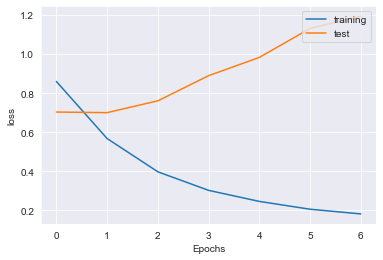

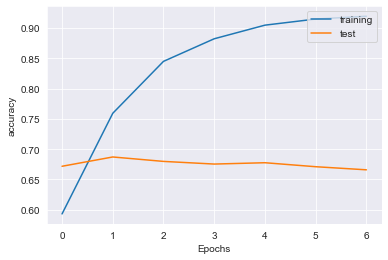

In [420]:
graph_model(history_lstm1, 'loss')
graph_model(history_lstm1, 'accuracy')

In [422]:
# LSTM model - Bidirectional
embed_dim=128

model_lstm2 = Sequential()
model_lstm2.add(layers.Embedding(input_dim = vocab_size,
                    output_dim = 128,
                    input_length = maxlen))
model_lstm2.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
model_lstm2.add(layers.GlobalMaxPool1D())
model_lstm2.add(layers.Dropout(0.2))
model_lstm2.add(layers.Dense(64, activation='relu'))
model_lstm2.add(layers.Dense(3, activation='softmax'))
          
model_lstm2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm2.summary())

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 23, 128)           1147008   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 23, 256)           263168    
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 256)               0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_60 (Dense)             (None, 3)                 195       
Total params: 1,426,819
Trainable params: 1,426,819
Non-trainable params: 0
___________________________________________

In [ ]:
history_lstm2, _, _, _ = predict(model_lstm2, 20, 32)

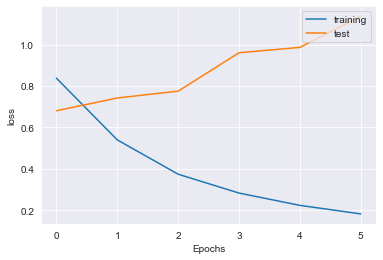

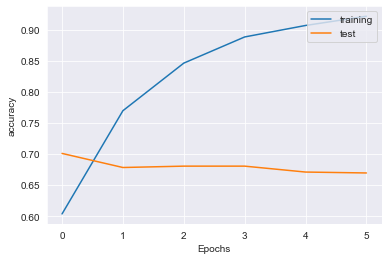

In [424]:
graph_model(history_lstm2, 'loss')
graph_model(history_lstm2, 'accuracy')

#### Observation

We can see our LSTM model hugely suffers from overfitting problem. Futhermore, current validation accuracy is on the same level as classical model such as Naive Bayes or Random Forest. 
In the next, let's try to import a pretrained model and see if we can get better result.

In [40]:
# Use GLOVE pretrained model
import os

GLOVE_DIR = "D:/Machine_Learning/GLOVE"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

400000it [00:11, 35848.51it/s]


In [41]:
print(f'found {len(embeddings_index)} word vectors.')

found 400000 word vectors.


This is huge list, we need to create a matrix containing words for our vocabulary

In [42]:
# Create a weight matrix for work vocabulary from our training set

embedding_matrix = np.zeros((vocab_size, 100))  # 100 for 100-dimensional version  
for word, i in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████████████████████████████| 8960/8960 [00:00<00:00, 641718.56it/s]


We chose 100-dimensional version, so the Embedding layer must be defined with output_dim set to 100.
Also, we do not want to update the learned word weights in this model, therefore we will set the trainable attribute for the model to be False.

In [32]:
# LSTM model - Bidirectional with GLOVE embedding
embed_dim=128

model_lstm3 = Sequential()
model_lstm3.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix], 
                     input_length=maxlen, trainable=False))
model_lstm3.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
model_lstm3.add(layers.GlobalMaxPool1D())
model_lstm3.add(layers.Dropout(0.2))
model_lstm3.add(layers.Dense(64, activation='relu'))
model_lstm3.add(layers.Dense(3, activation='softmax'))
          
model_lstm3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm3.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 100)           896100    
_________________________________________________________________
bidirectional (Bidirectional (None, 23, 256)           234496    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,147,239
Trainable params: 251,139
Non-trainable params: 896,100
__________________________________________

In [ ]:
hist_lstm3, train_lstm3, val_lstm3, test_lstm3 = predict(model_lstm3, 20, 32)

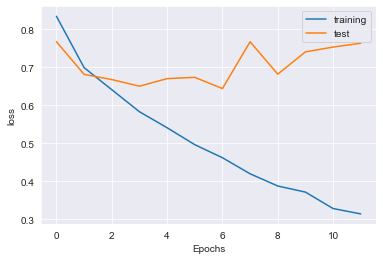

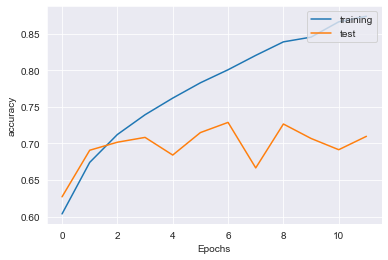

In [427]:
graph_model(hist_lstm3, 'loss')
graph_model(hist_lstm3, 'accuracy')

Even with the pretrained model, the LSTM is not reducing the overfitting of the data. In the next cell, we will try to optimize the model architecture. We will start by increasing drop_out parameters

In [314]:
# LSTM model - Bidirectional with GLOVE embedding
embed_dim=128

model_lstm4 = Sequential()
model_lstm4.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix], 
                     input_length=maxlen, trainable=False))
model_lstm4.add(layers.Dropout(0.4))
model_lstm4.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
model_lstm4.add(layers.GlobalMaxPool1D())
model_lstm4.add(layers.Dropout(0.2))
model_lstm4.add(layers.Dense(64, activation='relu'))
model_lstm4.add(layers.Dense(3, activation='softmax'))
          
model_lstm4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm4.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 23, 100)           896100    
_________________________________________________________________
dropout_59 (Dropout)         (None, 23, 100)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 23, 256)           234496    
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 256)               0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_34 (Dense)             (None, 3)               

In [ ]:
hist_lstm4, train_lstm4, val_lstm4, _ = predict(model_lstm4, 20, 32)

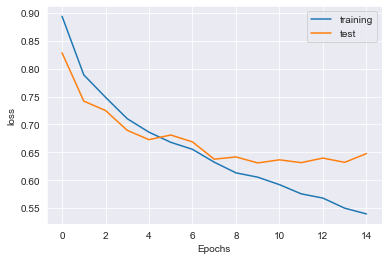

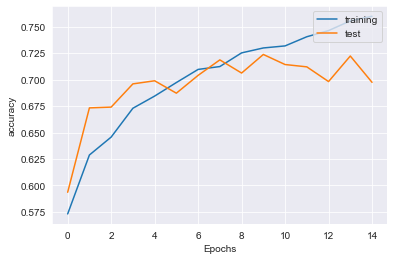

In [428]:
graph_model(hist_lstm4, 'loss')
graph_model(hist_lstm4, 'accuracy')

Increasing Dropout seems to help the predictions! Let see the classification report on training and validation result

In [58]:
def predict_df(y_true, y_pred):
    '''
    A simple function to put predicted results into a dataframe
    '''
    
    true_df = pd.DataFrame(y_true.idxmax(axis=1), columns=['true_emotion']).reset_index(drop=True)
    
    pred_df = pd.DataFrame(y_pred.argmax(axis=1), columns=['predicted'])
    pred_df['predicted'] = pred_df['predicted'].apply(lambda x: 'negative' if x==0 
                                                     else 'neutral' if x==1 
                                                     else 'positive' )
    
    merge_df = pd.merge(true_df, pred_df, left_index=True, right_index=True)
    
    print(classification_report(merge_df['true_emotion'], merge_df['predicted']))
    
    return merge_df

In [319]:
train_predict_df = predict_df(y_train, train_lstm4)
val_predict_df = predict_df(y_val, val_lstm4)

              precision    recall  f1-score   support

    negative       0.94      0.83      0.88      1368
     neutral       0.83      0.85      0.84      4109
    positive       0.72      0.74      0.73      2270

    accuracy                           0.82      7747
   macro avg       0.83      0.81      0.82      7747
weighted avg       0.82      0.82      0.82      7747

              precision    recall  f1-score   support

    negative       0.87      0.71      0.78       241
     neutral       0.73      0.76      0.75       726
    positive       0.55      0.58      0.56       401

    accuracy                           0.70      1368
   macro avg       0.72      0.68      0.70      1368
weighted avg       0.70      0.70      0.70      1368



The validation accuracy of has improved slightly, but in general it is still suffering training overfit. Next we will try to implement GRU network which seems to perform better for smaller datasets.

###  GRU

In [320]:
model_gru1 = Sequential()
model_gru1.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix], 
                     input_length=maxlen, trainable=False))
model_gru1.add(layers.Dropout(0.4))
model_gru1.add(layers.GRU(100))
model_gru1.add(layers.Flatten())
model_gru1.add(layers.Dropout(0.2))
model_gru1.add(layers.Dense(64, activation='relu'))
model_gru1.add(layers.Dense(3, activation='softmax'))

model_gru1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_gru1.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 23, 100)           896100    
_________________________________________________________________
dropout_61 (Dropout)         (None, 23, 100)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               60600     
_________________________________________________________________
flatten_3 (Flatten)          (None, 100)               0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_36 (Dense)             (None, 3)               

In [ ]:
hist_gru1, train_gru1, val_gru1, test_gru1 = predict(model_gru1, 20, 32)

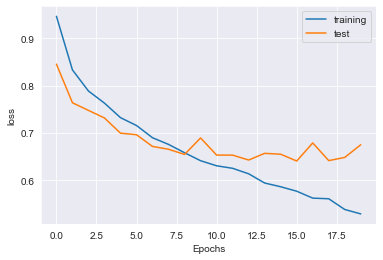

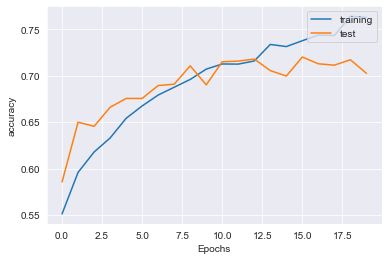

In [429]:
graph_model(hist_gru1, 'loss')
graph_model(hist_gru1, 'accuracy')

In [323]:
train_predict_df = predict_df(y_train, train_gru1)
val_predict_df = predict_df(y_val, val_gru1)

              precision    recall  f1-score   support

    negative       0.98      0.81      0.89      1368
     neutral       0.80      0.88      0.84      4109
    positive       0.75      0.69      0.72      2270

    accuracy                           0.81      7747
   macro avg       0.84      0.79      0.81      7747
weighted avg       0.82      0.81      0.81      7747

              precision    recall  f1-score   support

    negative       0.94      0.63      0.76       241
     neutral       0.71      0.81      0.76       726
    positive       0.58      0.55      0.56       401

    accuracy                           0.70      1368
   macro avg       0.74      0.66      0.69      1368
weighted avg       0.71      0.70      0.70      1368



We can see, there is not much of the difference in model performance betwen LSTM and GRU. We have noticed a strong imbalance in the class label in our dataset. Next, we will evaluate, if providing weights in the fit method will help to reduce the overfit.

###  Imbalanced Class 

In [324]:
df.emotion.value_counts()/df.shape[0]

neutral     0.530411
positive    0.293049
negative    0.176540
Name: emotion, dtype: float64

In [326]:
y_ohe_numpy = y_ohe.to_numpy()

In [327]:
from sklearn.utils.class_weight import compute_class_weight
 
y_integers = np.argmax(y_ohe_numpy, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

In [328]:
d_class_weights

{0: 1.8881431767337808, 1: 0.6284437825763217, 2: 1.137466307277628}

In [40]:
# Define callbacks and save final model
def predict_w(model, epochs, batch_size, weights):
    early_stop = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model_m.h5', monitor='val_loss',
                            save_best_only=True)]

    history = model.fit(X_train_seq, y_train, 
                     batch_size=batch_size, epochs=epochs, verbose=1, 
                     validation_data=(X_val_seq, y_val),
                     callbacks=early_stop,
                     class_weight=weights)
                               
    graph_model(history, 'loss')
    graph_model(history, 'accuracy')
    
    train_prediction = model.predict(X_train_seq, batch_size=batch_size)
    val_prediction = model.predict(X_val_seq, batch_size=batch_size)
    test_prediction = model.predict(X_test_seq, batch_size=batch_size)    
    
    return history, train_prediction, val_prediction, test_prediction 

In [332]:
# LSTM model - Bidirectional with GLOVE embedding
embed_dim=128

model_lstm5 = Sequential()
model_lstm5.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix], 
                     input_length=maxlen, trainable=False))
model_lstm5.add(layers.Dropout(0.4))
model_lstm5.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
model_lstm5.add(layers.GlobalMaxPool1D())
model_lstm5.add(layers.Dropout(0.2))
model_lstm5.add(layers.Dense(64, activation='relu'))
model_lstm5.add(layers.Dense(3, activation='softmax'))
          
model_lstm5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm5.summary())

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 23, 100)           896100    
_________________________________________________________________
dropout_65 (Dropout)         (None, 23, 100)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 23, 256)           234496    
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 256)               0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_40 (Dense)             (None, 3)               

In [ ]:
hist_lstm5, train_lstm5, val_lstm5, _ = predict_w(model_lstm5, 20, 32, d_class_weights)

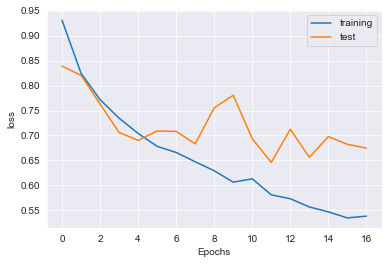

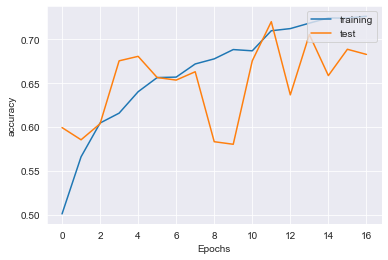

In [430]:
graph_model(hist_lstm5, 'loss')
graph_model(hist_lstm5, 'accuracy')

In [334]:
# GRU 
model_gru2 = Sequential()
model_gru2.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix], 
                     input_length=maxlen, trainable=False))
model_gru2.add(layers.Dropout(0.4))
model_gru2.add(layers.GRU(100))
model_gru2.add(layers.Flatten())
model_gru2.add(layers.Dropout(0.2))
model_gru2.add(layers.Dense(64, activation='relu'))
model_gru2.add(layers.Dense(3, activation='softmax'))

model_gru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_gru2.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 23, 100)           896100    
_________________________________________________________________
dropout_67 (Dropout)         (None, 23, 100)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 100)               60600     
_________________________________________________________________
flatten_4 (Flatten)          (None, 100)               0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_42 (Dense)             (None, 3)               

In [ ]:
hist_gru2, train_gru2, val_gru2, test_gru2 = predict_w(model_gru2, 20, 32, d_class_weights)

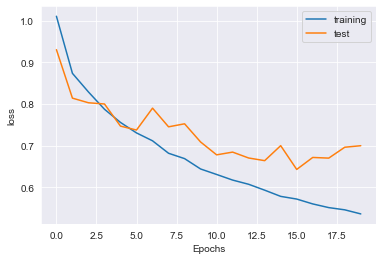

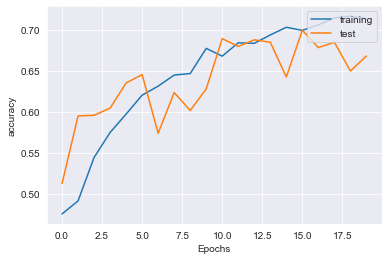

In [431]:
graph_model(hist_gru2, 'loss')
graph_model(hist_gru2, 'accuracy')

In [337]:
train_predict_df = predict_df(y_train, train_gru2)
val_predict_df = predict_df(y_val, val_gru2)


              precision    recall  f1-score   support

    negative       0.86      0.93      0.90      1368
     neutral       0.89      0.66      0.76      4109
    positive       0.61      0.86      0.71      2270

    accuracy                           0.77      7747
   macro avg       0.79      0.82      0.79      7747
weighted avg       0.80      0.77      0.77      7747

              precision    recall  f1-score   support

    negative       0.81      0.76      0.78       241
     neutral       0.81      0.58      0.68       726
    positive       0.50      0.78      0.61       401

    accuracy                           0.67      1368
   macro avg       0.71      0.70      0.69      1368
weighted avg       0.72      0.67      0.67      1368



Even though we add class weights, we do not see being improvement in the model performance.

### Final Modelling

In [43]:
def create_model(model_type, vocab_size, maxlen, embed_dim):
    '''
    Create and return a compiled model
    '''
    
    if model_type == 'lstm':
        
        model = Sequential()
        model.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                             weights=[embedding_matrix], 
                             input_length=maxlen, trainable=False))
        model.add(layers.Dropout(0.4))
        model.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
        model.add(layers.GlobalMaxPool1D())
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    elif model_type == 'gru':
                   
        model = Sequential()
        model.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                             weights=[embedding_matrix], 
                             input_length=maxlen, trainable=False))
        model.add(layers.Dropout(0.4))
        model.add(layers.GRU(100))
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(3, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [50]:
final_model = create_model('gru', vocab_size, maxlen, embed_dim=128)
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 100)           896100    
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 100)           0         
_________________________________________________________________
gru (GRU)                    (None, 100)               60600     
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

### Model Fit

In [51]:
checkpoint_path = 'final_model_weights/cp.{epoch:04d}.ckpt'

# Create a Model Check point
checkpoint = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

history_final = final_model.fit(X_train_seq, y_train,
                          batch_size=32, 
                          epochs=20, 
                          verbose=1,
                          validation_data=(X_val_seq, y_val),
                          callbacks= [checkpoint]
                         )
train_prediction = final_model.predict(X_train_seq, batch_size=32)
val_prediction = final_model.predict(X_val_seq, batch_size=32)
test_prediction = final_model.predict(X_test_seq, batch_size=32)  

Epoch 1/20
240/243 [============================>.] - ETA: 0s - loss: 0.9424 - accuracy: 0.5484
Epoch 00001: val_loss improved from inf to 0.82760, saving model to final_model_weights\cp.0001.ckpt
243/243 [==============================] - 2s 9ms/step - loss: 0.9416 - accuracy: 0.5491 - val_loss: 0.8276 - val_accuracy: 0.6096
Epoch 2/20
241/243 [============================>.] - ETA: 0s - loss: 0.8302 - accuracy: 0.5962
Epoch 00002: val_loss improved from 0.82760 to 0.78543, saving model to final_model_weights\cp.0002.ckpt
243/243 [==============================] - 2s 7ms/step - loss: 0.8297 - accuracy: 0.5966 - val_loss: 0.7854 - val_accuracy: 0.6177
Epoch 3/20
241/243 [============================>.] - ETA: 0s - loss: 0.7933 - accuracy: 0.6084
Epoch 00003: val_loss improved from 0.78543 to 0.77659, saving model to final_model_weights\cp.0003.ckpt
243/243 [==============================] - 2s 7ms/step - loss: 0.7930 - accuracy: 0.6085 - val_loss: 0.7766 - val_accuracy: 0.6367
Epoch 4/

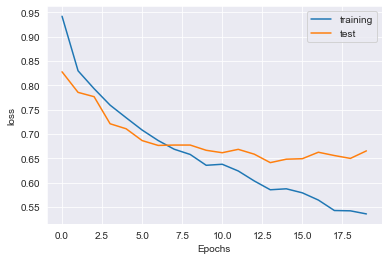

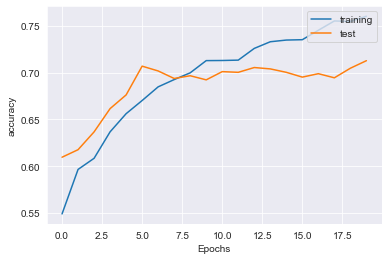

In [52]:
graph_model(history_final, 'loss')
graph_model(history_final, 'accuracy')

In [54]:
# Look inside save folder.
# sorted(os.listdir('final_model_weights'))

### Prediction

In [55]:
def evaluate_nn(model, X_test, y_test):
    """Print model accuracy on test set."""
    
    loss, acc = model.evaluate(X_test, y_test)
    print(f'Model Accuracy:\n\t{round(acc, 3)}')

    
# Evaluate model
evaluate_nn(final_model, X_test_seq, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.7284 - accuracy: 0.7098
Model Accuracy:
	0.71


In [56]:
test_prediction = final_model.predict(X_test_seq, batch_size=32)  

In [59]:
test_predict_df = predict_df(y_test, test_prediction)

              precision    recall  f1-score   support

    negative       0.83      0.69      0.75       179
     neutral       0.73      0.80      0.76       537
    positive       0.61      0.57      0.59       297

    accuracy                           0.71      1013
   macro avg       0.72      0.68      0.70      1013
weighted avg       0.71      0.71      0.71      1013



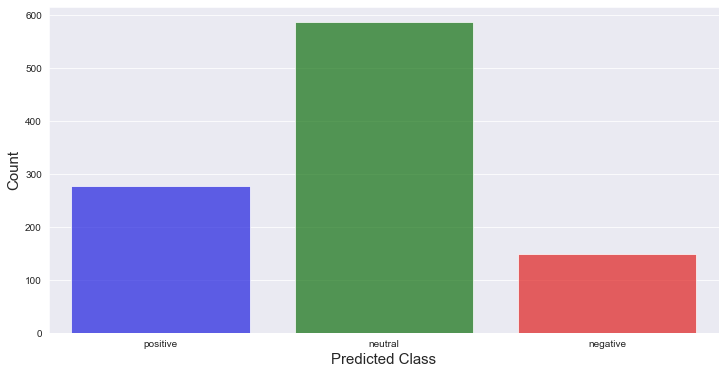

In [61]:
fig = plt.figure(figsize=(12,6))
colors = ['b']
sns.countplot(x='predicted', data=test_predict_df, 
              palette={'positive':'b', 'negative':'r', 'neutral':'g'}, alpha=0.7)
plt.xlabel("Predicted Class", fontsize=15)
plt.ylabel("Count", fontsize=15);

In [62]:
# load helper function
from custom_confusion_matrix import create_confusion_matrix

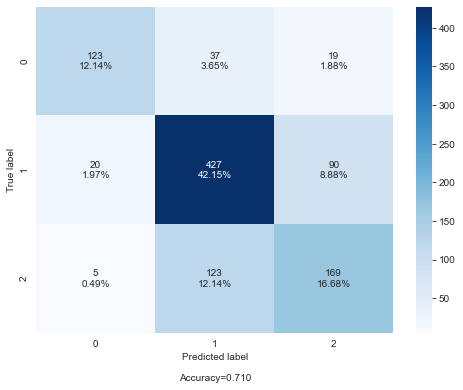

In [63]:
cm = confusion_matrix(test_predict_df.true_emotion, test_predict_df.predicted)

create_confusion_matrix(cm, figsize=(8,6), cbar=True)

In [64]:
# Examples of Test Prediction
X_test_orig = X_test.copy(deep=True)
X_test_orig.reset_index(drop=True, inplace=True)
X_test_orig = pd.DataFrame(X_test_orig.values, columns=['tweet'])
X_test_pred_merge = pd.merge(X_test_orig, test_predict_df, left_index=True, right_index=True)
X_test_pred_merge.head()

tweet true_emotion predicted
0         haha awesomely rad ipad app hollergram via     positive  positive
1       what are you talking about back all the time     negative   neutral
2  talking about how mobile phones google earth e...      neutral   neutral
3  tweet this register for exclusive passes event...      neutral   neutral
4  thanks will keep mind tho have lately been unh...     negative  negative

In [65]:
print(X_test_pred_merge['tweet'][5])
print(X_test_pred_merge['true_emotion'][5])
print(X_test_pred_merge['predicted'][5])

interrupt your regularly scheduled geek programming with big news google circles
positive
neutral


In [66]:
print(X_test_pred_merge['tweet'][100])
print(X_test_pred_merge['true_emotion'][100])
print(X_test_pred_merge['predicted'][100])

anybody seen the 6th apple store yet
neutral
neutral


In [67]:
print(X_test_pred_merge['tweet'][700])
print(X_test_pred_merge['true_emotion'][700])
print(X_test_pred_merge['predicted'][700])

apple the most elegant fascist company america flipboard
negative
negative


In [73]:
print(X_test_pred_merge['tweet'][900])
print(X_test_pred_merge['true_emotion'][900])
print(X_test_pred_merge['predicted'][900])

windows the scarborough building corner 6th amp congress blacked out apple pop store being born welivehere
positive
neutral


In [75]:
X_test_pred_merge.head()

tweet true_emotion predicted
0         haha awesomely rad ipad app hollergram via     positive  positive
1       what are you talking about back all the time     negative   neutral
2  talking about how mobile phones google earth e...      neutral   neutral
3  tweet this register for exclusive passes event...      neutral   neutral
4  thanks will keep mind tho have lately been unh...     negative  negative

In [74]:
from wordcloud import WordCloud

In [76]:
def create_wordcloud(df, col):
    wordcloud = WordCloud(background_color='black').generate(str(col))
    plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
    plt.axis("off")
    plt.show()  

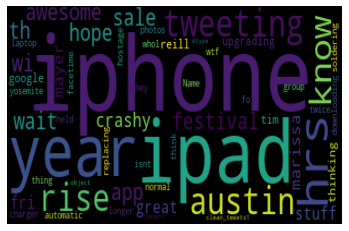

In [94]:
create_wordcloud(df.loc[df['emotion']=='negative'], df['clean_tweets1'])

It is notable to observe the tweet 'crashy' for the negative tweets! It is very strong behaviour of a product that can drive negative sentiment towards it.

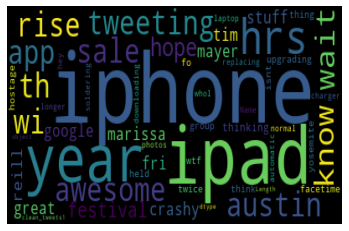

In [90]:
create_wordcloud(df.loc[df['emotion']=='positive'], df['clean_tweets1'])

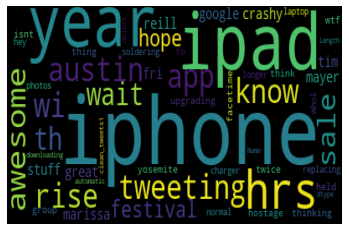

In [91]:
create_wordcloud(df.loc[df['emotion']=='neutral'], df['clean_tweets1'])

## Conclusion

The current study shows there is a huge problem of training overfit in the current implementation. Nevertheless, the neural network based architecture seems to perform best over the traditional machine learning architecture. Two neural architectures: LSTM and GRU performs almost on a similar accuracy level. Furthermore, these architecture performed very well against the baseline Naive Bayes Classifier. Data augmenation will be key in future modeling improvement due to the presence of large class imbalance in the dataset. In general, the neural net based architecture has potential to improve further upon and therefore successfully make accurate prediction of tweets sentiments.

### Actionable Insights

Although, the model did not perform on the higher accuracy level. Nevertheless, negative tweets data were analyzed to identify what kind of products behavior is driving the people sentiment. It was found that tweets like 'crashy' has appeared multiple times in the word cloud. A product that crashes frequently is definitely a bad sign for branding. It is highly recommended to analyze data on 'crash' of a particular product and find the root cause of the behavior. 

### Future Recommendation

Current modeling shows the impact of class imbalance is significant in prediction accuracy. Therefore, for large scale production, it is recommended have more balanced dataset as much as possible. The modeling results have shown that there is a strong training overfit given the smaller size of the dataset. It is recommended to collect more relevant dataset to reduce the training overfit. 

It is also suggested to look into the tweets that has been misclassified, whether it is labeling issue issue or required more text processing.  This will be critical for the future modeling improvement. 

More advanced algorithms such as BERT, GPT which are based on Transformer may be beneficial to achieve higher performance. However, this may require more computation power.